In [1]:
import glob
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from confidence_interval import calculate_confidence_interval, compare_model_accuracies

model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]

Simple1d: 0.571 ± 0.039
Original Simple1d: 0.675 ± 0.033
Simple1dEmbedding: 0.585 ± 0.049
Original Simple1dEmbedding: 0.836 ± 0.028
Simple2d: 0.671 ± 0.047
Original Simple2d: 0.724 ± 0.031
Simple2dEmbedding: 0.550 ± 0.043
Original Simple2dEmbedding: 0.824 ± 0.029
ResNet50: 0.653 ± 0.040
Original ResNet50: 0.743 ± 0.035
ResNet50Embedding: 0.668 ± 0.040
Original ResNet50Embedding: 0.846 ± 0.024
Simple1d: 0.608 ± 0.033
Original Simple1d: 0.743 ± 0.027
Simple1dEmbedding: 0.673 ± 0.037
Original Simple1dEmbedding: 0.795 ± 0.026
Simple2d: 0.628 ± 0.049
Original Simple2d: 0.732 ± 0.041
Simple2dEmbedding: 0.734 ± 0.030
Original Simple2dEmbedding: 0.829 ± 0.022
ResNet50: 0.633 ± 0.040
Original ResNet50: 0.733 ± 0.030
ResNet50Embedding: 0.716 ± 0.036
Original ResNet50Embedding: 0.806 ± 0.026


<Figure size 900x600 with 0 Axes>

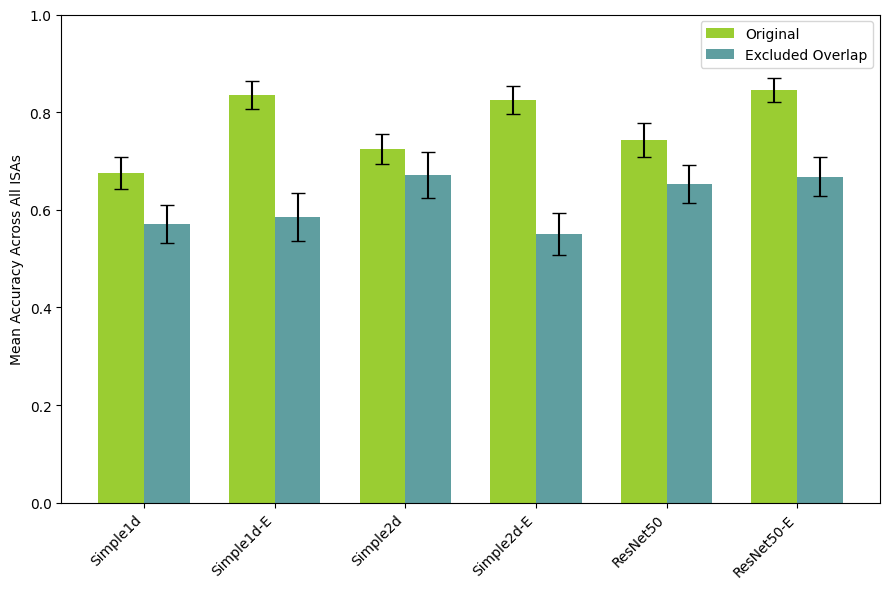

<Figure size 900x600 with 0 Axes>

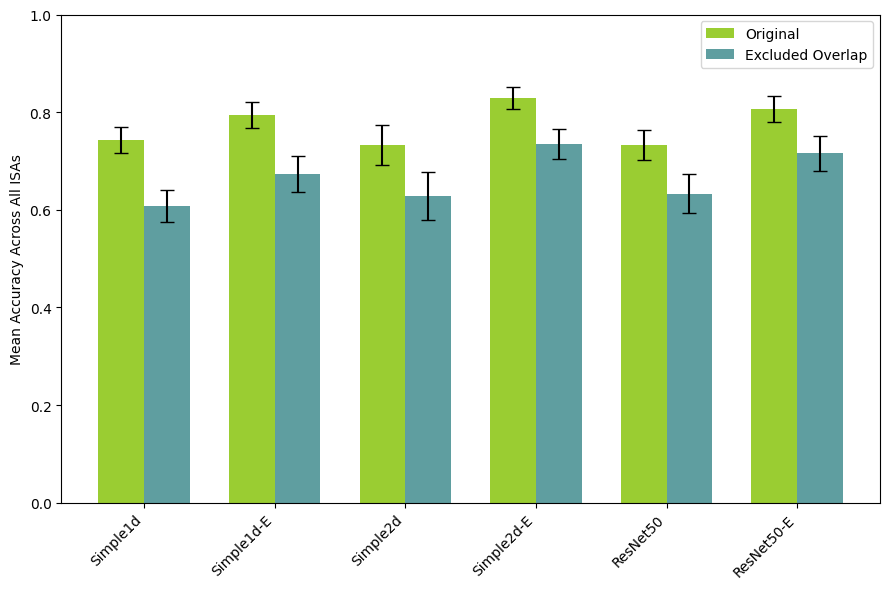

In [2]:
# Specify the directory containing the CSV files
directory = "./input/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "Combined-*.csv"))
df_all = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

for target_feature in target_features:
    model_results = {}
    arch_model_results = {}
    all_architectures = set()

    # Find all architecture columns
    arch_columns = [
        col
        for col in df_all.columns
        if col.startswith("test_accuracy_") and col != "test_accuracy"
    ]
    architectures = [col.replace("test_accuracy_", "") for col in arch_columns]
    all_architectures.update(architectures)

    exclude_architectures = [
        # ISADetect
        "Alpha",
        "ARM64",
        "ARMel",
        "ARMhf",
        "HP-PA",
        "IA-64",
        "M68k",
        "MIPSeb",
        "MIPSel",
        "PPCeb",
        "PPCel",
        "RISC-V",
        "S-390",
        "SuperH",
        "X86-64",
        "X86",
        # BuildCross
        "AxisCris",
        "Blackfin",
        "CompactRisc",
        "Epiphany",
        "FR-V",
        "FR30",
        "FT32",
        "H8-300",
        "IQ2000",
        "M32R",
        "MCore",
        "Mico32",
        "MicroBlaze",
        "MMIX",
        "MN10300",
        "Moxie",
        "MSP430",
        "NDS32",
        "NIOS-II",
        "RL78",
        "RX",
        "Stormy16",
        "TMS320C6x",
        "V850",
        "Visium",
        "Xtensa",
    ]

    all_architectures -= set(exclude_architectures)

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["validator.name"] == "train_test_separate_datasets")
            & (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        # Calculate the sum of all instance_count_* columns for each row
        samples_count_cols = [
            col for col in df.columns if col.startswith("instance_count_")
        ]
        df["total_samples_count"] = df[samples_count_cols].sum(axis=1).astype(int)

        # Ensure all rows have the same total instance count
        assert (
            df["total_samples_count"] == df["total_samples_count"].iloc[0]
        ).all(), "Not all rows have the same samples count."

        samples_per_run = int(df["total_samples_count"].iloc[0])

        accuracies = []
        for _, row in df.iterrows():
            arch_weighted_accuracies = []
            total_instance_count = 0

            for architecture in all_architectures:
                if not math.isnan(row[f"test_accuracy_{architecture}"]):
                    arch_accurary = row[f"test_accuracy_{architecture}"]
                    arch_instance_count = row[f"instance_count_{architecture}"]
                    total_instance_count += arch_instance_count

                    arch_weighted_accuracies.append(arch_accurary * arch_instance_count)

            accuracies.append(np.sum(arch_weighted_accuracies) / total_instance_count)

        model_mean, model_conf_95, _, _ = calculate_confidence_interval(
            accuracies=accuracies, n_samples=samples_per_run, confidence=0.95
        )

        original_accuracies = df["test_accuracy"].tolist()
        original_mean, original_conf_95, _, _ = calculate_confidence_interval(
            accuracies=original_accuracies, n_samples=samples_per_run, confidence=0.95
        )

        model_results[model_name] = (
            model_mean,
            model_conf_95,
            original_mean,
            original_conf_95,
        )

    # Create bar chart aggregated by model
    plt.figure(figsize=(9, 6))
    model_means = []
    model_conf_95s = []
    model_original_means = []
    model_original_conf_95s = []

    for model in model_names:
        mean, conf_95, original_mean, original_conf_95 = model_results[model]
        model_means.append(mean)
        model_conf_95s.append(conf_95)
        model_original_means.append(original_mean)
        model_original_conf_95s.append(original_conf_95)
        print(f"{model}: {mean:.3f} ± {conf_95:.3f}")
        print(f"Original {model}: {original_mean:.3f} ± {original_conf_95:.3f}")

    xticks = [model.replace("Embedding", "-E") for model in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9, 6))
    rects1 = ax.bar(
        x - width / 2,
        model_original_means,
        width,
        yerr=model_original_conf_95s,
        capsize=5,
        label="Original",
        color="yellowgreen",
    )
    rects2 = ax.bar(
        x + width / 2,
        model_means,
        width,
        yerr=model_conf_95s,
        capsize=5,
        label="Excluded Overlap",
        color="cadetblue",
    )

    ax.set_xticks(x)
    ax.set_xticklabels(xticks, rotation=45, ha="right")
    ax.legend()

    plt.ylabel("Mean Accuracy Across All ISAs")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(
        f"output/combined-{target_feature.replace('_', '').lower()}-by-model-exclude-overlap.svg"
    )